# Marine Heatwaves Definition

This document describes the `marineHeatWaves` module for python which implements the Marine Heatwave (MHW) definition of Hobday et al. (*manuscript submitted to Progress in Oceanography*). This software is demonstrated by applying the MHW definition to a stochastic red noise process. This was developed as an interactive ipython notebook which the user can run themselves provided they have the required python modules (`numpy`, `scipy`, `datetime`, and `matplotlib`).

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from cmocean import cm
import datetime as dt
import pandas as pd
import xarray as xr
from xml.dom import minidom
import urllib, requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from thredds_crawler.crawl import Crawl
%pylab inline

/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

## Generate synthetic temperature time series

The following code will generate a synthetic daily temperature time series, over the time span 1 Jan 1982 to 31 Dec 2014, using an order-1 autoregressive process.

In [3]:
# Find all do the netcdf files in this catalog
c = Crawl("http://thredds.cencoos.org/thredds/catalog/cencoos/staticsensors/m1/catalog.xml", select=[".*TMTS.nc"])
# Lets filter out files that contain _D_M in the name, which indicates that it is the surface meteorological data
# This piece of funky code 
urls = [s.get("url") for d in c.datasets if d.name.find("_D_M") == -1 for s in d.services if (s.get("service").lower() == "opendap") ] 
[print(u) for u in sorted(urls)]

http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19890821_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19920116_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19920831_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19931104_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19950315_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19960625_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19970731_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19980923_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19991104_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_20001006_D_TMTS.nc
http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_20011029_D_TMTS.nc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
ds = xr.open_dataset(urls[0])

In [5]:
surface_temp = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TEMP'].values
dateTime = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TIME'].values

In [6]:
ds

<xarray.Dataset>
Dimensions:    (DEPTH: 11, LATITUDE: 1, LONGITUDE: 1, TIME: 52272)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2017-08-08T19:55:38 2017-08-08T20:05:38 ...
  * DEPTH      (DEPTH) float32 1.0 10.0 20.0 40.0 60.0 80.0 100.0 150.0 ...
  * LATITUDE   (LATITUDE) float32 36.75
  * LONGITUDE  (LONGITUDE) float32 -122.03
Data variables:
    TEMP       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    TEMP_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PSAL       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PSAL_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CNDC       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CNDC_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PRES       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    PRES_QC    (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
Attributes:
    title:                           "Gridded 10 minute MBARI Mooring M1 Sea ...
    date_created:                    2018-09-19T15:42:58Z


In [7]:
t = ds.where(ds['TEMP_QC'] == 0)
q = ds.where(ds['TEMP_QC'] != 0)

In [8]:
ds = xr.open_dataset('http://thredds.cencoos.org/thredds/dodsC/cencoos/staticsensors/m1/OS_M1_19890821_D_TMTS.nc')

/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'TEMP' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'PSAL' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'CNDC' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'PRES' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [9]:
ds['TEMP_QC']

<xarray.DataArray 'TEMP_QC' (TIME: 827, DEPTH: 11, LATITUDE: 1, LONGITUDE: 1)>
array([[[[4.]],

        ...,

        [[4.]]],


       ...,


       [[[1.]],

        ...,

        [[1.]]]], dtype=float32)
Coordinates:
  * TIME       (TIME) datetime64[ns] 1989-08-21 1989-08-22 1989-08-23 ...
  * LATITUDE   (LATITUDE) float64 36.75
  * LONGITUDE  (LONGITUDE) float64 -122.0
  * DEPTH      (DEPTH) float64 1.0 10.0 20.0 40.0 60.0 80.0 100.0 150.0 ...
Attributes:
    long_name:      Quality Flag
    standard_name:  Quality Flag
    units:           
    valid_min:      0.0
    valid_max:      9.0
    QC_indicator:   5.0
    conventions:    OceanSITES reference Table 2
    flag_values:    0,1,2,3,4,5,7,8,9

In [4]:
for i, fname in enumerate(sorted(urls)[:]):
    print(fname.split('/')[-1])
    ds = xr.open_dataset(fname)
#     ds = ds.where(ds['TEMP_QC'] == 0)
    if i == 0:
        surface_temp = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TEMP'].values
        dateTime = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TIME'].values
    else:
        try:
            surface_temp_append = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TEMP'].values
            dateTime_append = ds.isel(DEPTH=0, LATITUDE=0, LONGITUDE=0)['TIME'].values
            surface_temp = np.concatenate((surface_temp,surface_temp_append))
            dateTime = np.concatenate((dateTime,dateTime_append))
        except:
            surface_temp_append = ds.isel(DEPTH=0, latitude=0, longitude=0)['TEMP'].values
            dateTime_append = ds.isel(DEPTH=0, latitude=0, longitude=0)['TIME'].values
            surface_temp = np.concatenate((surface_temp,surface_temp_append))
            dateTime = np.concatenate((dateTime,dateTime_append))

OS_M1_19890821_D_TMTS.nc


/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'TEMP' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'PSAL' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'CNDC' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'PRES' has multiple fill values {-1e+34, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


OS_M1_19920116_D_TMTS.nc
OS_M1_19920831_D_TMTS.nc
OS_M1_19931104_D_TMTS.nc
OS_M1_19950315_D_TMTS.nc
OS_M1_19960625_D_TMTS.nc


/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'TEMP_QC' has multiple fill values {1.0, 9.0}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


OS_M1_19970731_D_TMTS.nc
OS_M1_19980923_D_TMTS.nc
OS_M1_19991104_D_TMTS.nc
OS_M1_20001006_D_TMTS.nc
OS_M1_20011029_D_TMTS.nc
OS_M1_20011113_D_TMTS.nc
OS_M1_20021017_D_TMTS.nc
OS_M1_20031107_D_TMTS.nc
OS_M1_20041021_D_TMTS.nc
OS_M1_20051020_D_TMTS.nc
OS_M1_20061012_D_TMTS.nc
OS_M1_20071106_D_TMTS.nc
OS_M1_20081008_D_TMTS.nc
OS_M1_20091020_D_TMTS.nc


/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'TEMP' has multiple fill values {9.0, -1e+34}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


OS_M1_20101027_D_TMTS.nc
OS_M1_20120222_D_TMTS.nc
OS_M1_20130918_D_TMTS.nc
OS_M1_20140716_D_TMTS.nc
OS_M1_20150801_D_TMTS.nc
OS_M1_20160829_D_TMTS.nc
OS_M1_20170808_D_TMTS.nc


In [5]:
df = pd.DataFrame(data={'dateTime':dateTime,'temp':surface_temp})
df.index = df['dateTime']
df = df[(df['temp'] < 20) & (df['temp'] > 8)]
# ix = np.where((surface_temp < 24) & (surface_temp > 5))
# surface_temp = surface_temp[ix]
# dateTime = dateTime[ix]
# fig, ax = plt.subplots()
# ax.plot(dateTime, surface_temp)

__Convert DateTime objects to ordinal times__

In [6]:
df_clean = df.dropna()
daily = df_clean.resample('1D').mean()
daily['dateTime'] = daily.index

In [7]:
daily['date'] = daily['dateTime'].apply(lambda x: x.toordinal())


## Marine Heatwave Detection

The marineHeatWaves (`mhw`) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (`detect`) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs. We first run the MHW detection algorithm which returns the variable `mhws`, consisting of the detected MHWs, and `clim`, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:


In [8]:
mhws, clim = mhw.detect(daily['date'].values, daily['temp'].values)

In [9]:
clim

{'thresh': array([16.18820886, 16.19096593, 16.1943806 , ..., 15.8323651 ,
        15.86392635, 15.89878778]),
 'seas': array([14.18915721, 14.19539162, 14.20345454, ..., 13.99823816,
        14.01894056, 14.03882636]),
 'missing': array([False,  True, False, ..., False, False, False])}

This algorithm has detected the following number of MHW events:

In [10]:
mhws['n_events']

45

The first ten events, for example, have the following maximum intensities (in $^\circ$C):

In [11]:
mhws['intensity_max'][0:10]

[1.843876623338268,
 3.274756739216466,
 3.255510914710264,
 3.095611910666193,
 3.8192115906746196,
 3.2217189727290947,
 2.1022917839788615,
 1.7502839488367883,
 4.034269517467873,
 2.1993593092887647]

Let's have a look at some properties of the event with the largest maximum intensity

In [12]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print('Duration:', mhws['duration'][ev], 'days')
print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 4.800091928051366 deg. C
Average intensity: 2.884552567184612 deg. C
Cumulative intensity: 216.34144253884588 deg. C-days
Duration: 75 days
Start date: 17 July 2014
End date: 29 September 2014


In [13]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


and a closer look at the identified MHW event:

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


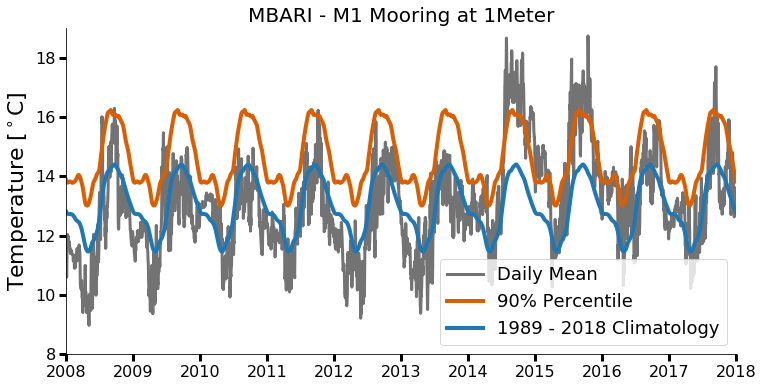

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

# Plot SST, seasonal cycle, and threshold
ax.plot(daily['dateTime'], daily['temp'], color='.45',label='Daily Mean',lw=3)
ax.plot(daily['dateTime'], clim['thresh'], color='#d95f02',label='90% Percentile',lw=4)
ax.plot(daily['dateTime'], clim['seas'], color='#1f78b4',label='1989 - 2018 Climatology',lw=4)
ax.set_title('MBARI - M1 Mooring at 1Meter',size=20)
ax.set_xlim(daily.iloc[0]['dateTime'], daily.iloc[-1]['dateTime'])
ax.set_ylim(8,19)
ax.set_ylabel(r'Temperature [$^\circ$C]',size=22)

years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
# # format the ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(mdates.YearLocator())
ax.xaxis.set_tick_params(which='both',width=2,length=5)
ax.yaxis.set_tick_params(which='both',width=2,length=5)
ax.tick_params(axis='both', labelsize=16)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=18)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(which='both',width=3,length=7)
ax.xaxis.set_tick_params(which='major',width=3,length=7)
ax.set_xlim(dt.datetime(2008,1,1),dt.datetime(2018,1,1))
plt.savefig('M1_climatology.png',dpi=300,bbox_inches='tight',pad_inches=.25)


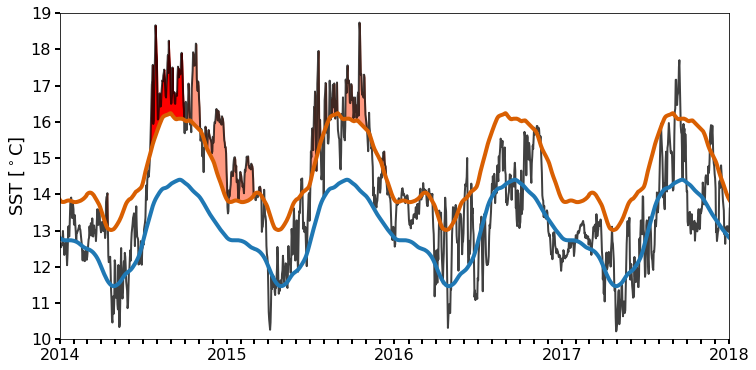

In [15]:
fig, ax2 = plt.subplots()
fig.set_size_inches(12,6)

# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(daily['date'].values ==mhws['time_start'][ev0])[0][0]
    t2 = np.where(daily['date'].values==mhws['time_end'][ev0])[0][0]
    ax2.fill_between(daily.iloc[t1:t2+1]['dateTime'].values, daily.iloc[t1:t2+1]['temp'].values, clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5),)
# Find indices for MHW of interest and shade accordingly
t1 = np.where(daily['date'].values==mhws['time_start'][ev])[0][0]
t2 = np.where(daily['date'].values==mhws['time_end'][ev])[0][0]
plt.fill_between(daily.iloc[t1:t2+1]['dateTime'].values, daily.iloc[t1:t2+1]['temp'].values, clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
ax2.plot(daily['dateTime'], daily['temp'], color='k',alpha=.75,label='Daily Mean',lw=2)
ax2.plot(daily['dateTime'], clim['thresh'], color='#d95f02',label='90% Percentile',lw=4)
ax2.plot(daily['dateTime'], clim['seas'], color='#1f78b4',label='1989 - 2018 Climatology',lw=4)

ax.set_title('Temperature @ 1M (black), seasonal climatology (blue), \
           threshold (green), detected MHW events (shading)')
ax2.set_xlim(dt.datetime(2014,1,1),dt.datetime(2018,1,1))
ax2.set_ylim(10,19)
ax2.set_ylabel(r'SST [$^\circ$C]',size=18)
ax2.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='both', labelsize=16)

myFmt = DateFormatter("%m %Y")

ax2.xaxis.set_major_formatter(myFmt)
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
# format the ticks
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)
ax2.xaxis.set_tick_params(which='both',width=2,length=5)
ax2.yaxis.set_tick_params(which='both',width=2,length=5)

ax2.set_xlim(dt.datetime(2014,1,1),dt.datetime(2018,1,1))
plt.savefig('M1_MHW.png',dpi=300,bbox_inches='tight',pad_inches=.25)

## Rotate date labels automatically
# fig.autofmt_xdate()

Yep, It's certainly picked out the largest event in the series (dark red shading). This event also seems to have been preceded and succeeded by a number of shorter, weaker events (light red shading). Let's have a look at how the MHW statistics are distributed across all the detected events:

Text(0.5,0,'MHW event number')

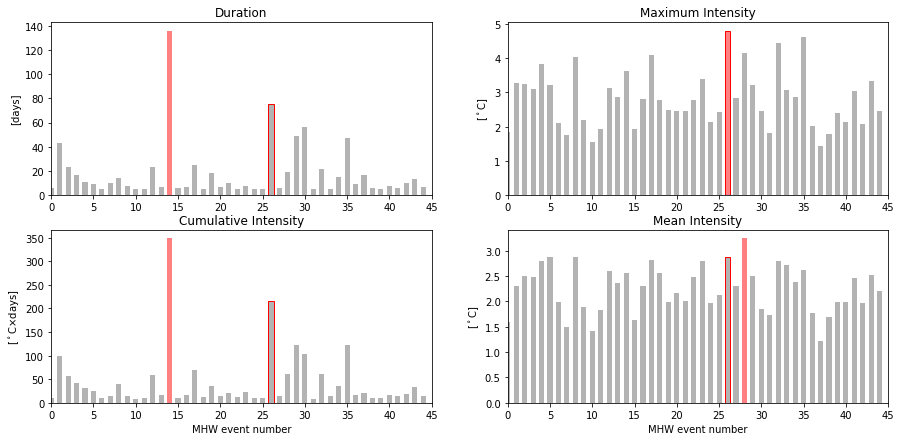

In [20]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws['intensity_max'])
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws['intensity_mean'])
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws['intensity_cumulative'])
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number')

The red shaded bars show the largest event on record by duration, maximum intensity, cumulative intensity, and mean intensity, while the red-outlined bars show the specific event chosen above (which happens to be largest by maximum intensity). We can see how this event ranks according to the other metrics as follows:

In [21]:
rank, returnPeriod = mhw.rank(t, mhws)
print("The 07/2014 event is ranked number " + str(rank['duration'][ev]) + " by duration")
print("The 07/2014 event is ranked number " + str(rank['intensity_max'][ev]) + " by maximum intensity")
print("The 07/2014 event is ranked number " + str(rank['intensity_mean'][ev]) + " by mean intensity")
print("The 07/2014 event is ranked number " + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 07/2014 event is ranked number 2 by duration
The 07/2014 event is ranked number 1 by maximum intensity
The 07/2014 event is ranked number 2 by mean intensity
The 07/2014 event is ranked number 2 by cumulative intensity


/anaconda3/lib/python3.6/site-packages/marineHeatWaves.py:835: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  nYears = len(t)/365.25


We can even look at the return periods for events with those properties:

In [22]:
print("The return period for an event with this duration was " + str(returnPeriod['duration'][ev]) + " years")
print("The return period for an event with this maximum intensity was " + str(returnPeriod['intensity_max'][ev]) + " years")
print("The return period for an event with this mean intensity was " + str(returnPeriod['intensity_mean'][ev]) + " years")
print("The return period for an event with this cumulative intensity was " + str(returnPeriod['intensity_cumulative'][ev]) + " years")

The return period for an event with this duration was 0.5164271047227926 years
The return period for an event with this maximum intensity was 1.0328542094455853 years
The return period for an event with this mean intensity was 0.5164271047227926 years
The return period for an event with this cumulative intensity was 0.5164271047227926 years


## Block-averaged Marine Heatwave properties

The marineHeatWaves (`mhw`) module also consists of functions to calculate the average of MHW properties over blocks in time (e.g., annually, decadally). The block-averaging function (`blockAverage`) takes as input a set of detected MHWs (i.e., the output from `detect`, the detection function described above) and outputs the MHW properties averaged over the specified block-length. This output can then be passed through the `meanTrend` function in order to calculate the time-mean and linear trend of the MHW properties over the measurement period.

Let's start by applying the block-averaging function to the Mediterranean MHWs which are stored in the variable `mhws`, using the default block length of 1 year (i.e., annual averages):

In [23]:
mhwBlock = mhw.blockAverage(daily['date'].values, mhws)

The variable `mhwBlock` has a set of keys which are time series of the MHW properties over the blocks. The central year of the blocks are stored in the key `years_centre` so we can look at, as an example, time series of MHW counts in each year and the average maximum intensity in each year:


Text(0.5,1,'Average MHW maximum intensity by year')

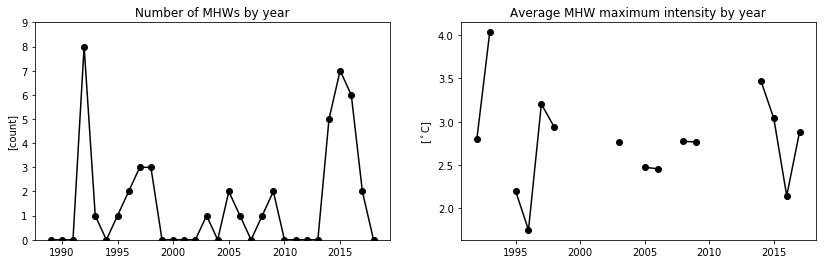

In [24]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(mhwBlock['years_centre'], mhwBlock['count'], 'k-o')
plt.ylim(0,9)
plt.ylabel('[count]')
plt.title('Number of MHWs by year')
plt.subplot(1,2,2)
plt.plot(mhwBlock['years_centre'], mhwBlock['intensity_max'], 'k-o')
plt.ylabel(r'[$^\circ$C]')
plt.title('Average MHW maximum intensity by year')

We can calculate the mean and trend of the MHW properties using the `meanTrend` function:

In [25]:
mean, trend, dtrend = mhw.meanTrend(mhwBlock)
print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['count']) > dtrend['count']) + "\n")

print("The average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
This trend is statistically significant (p<0.05): " \
+ str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

There are on average 1.5 MHWs in each year, 
 with a linear trend of 0.4160177975528362 MHW events per decade 
 This trend is statistically significant (p<0.05): False

The average maximum intensity is 2.780422434964444 deg. C, 
 with a linear trend of -0.018194278146765004 deg. C per decade 
 This trend is statistically significant (p<0.05): False


In [28]:
import altair as alt

monthly = daily.resample('1M').mean()
monthly['dateTime'] = monthly.index

In [30]:
chart = alt.Chart(
    monthly,
    title="M1 SST mean"
).mark_rect().encode(
    x=alt.X('dateTime:O', timeUnit='month'),
    y=alt.Y('dateTime:O', timeUnit='year'),
    color=alt.Color('temp:Q',aggregate='mean'),
        tooltip=[
        alt.Tooltip('date:T', timeUnit='yearmonth', title='Date'),
        alt.Tooltip('temp:Q',title='SST')
    ]
).properties(width=400)
chart.save('m1_sst_chart.html')